# Logistic Regression

Font: https://www.datacamp.com/community/tutorials/understanding-logistic-regression-python

Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import seaborn as sns
import numpy as np

Creating a df with the disease rates for each city and their respective RISK value (1, if it belongs to a high risk cluster, and 0 otherwise).

In [18]:
cities = pd.read_csv('../../SatScan/muncod_risk_2015_to_2017.csv', index_col=[0])

disease = ""
path = '../../TabNet/Rates/'
all_files = glob.glob(path + "*.csv")
diseases_list = []
all_diseases = cities
for file in all_files:
    file_name = file.split("\\")[1]
    disease = file_name.split("_RATE")[0]
    disease_df = pd.read_csv(path + disease + '_RATE_15_17.csv', sep=',', index_col=0)
    disease_df = disease_df[["RATE", "MUNCOD"]]
    disease_df.rename(columns={"RATE": disease}, inplace=True)

    all_diseases = pd.merge(disease_df, all_diseases, left_on="MUNCOD", right_on="MUNCOD", how="inner")
df = all_diseases.drop('MUNCOD', 1)
df = df.drop('TRAUMATISMO_INTRACRANIANO', 1) # We remove Traumatismo Intracraniano (low p-value on Spearman test)

In [21]:
df.head(12)

,OSTEOPOROSE,INSUFICIENCIA_RENAL,INSUFICIENCIA_CARDIACA,HIPERTENSAO_ESSENCIAL,ESCLEROSE_MULTIPLA,EPILEPSIA,ENXAQUECA,DPOC,DORSOPATIAS,DOENCA_DE_PARKINSON,DIABETES_MELLITUS,CANCER,ASMA,AIDS,RISK
0,9.155131,20.916400,125.488970,410.338491,1.303203,44.410713,7.830122,350.326527,6.537821,1.303203,155.440974,92.792639,210.422725,1.310427,0
1,9.155131,20.916400,125.488970,410.338491,1.303203,44.410713,7.830122,350.326527,6.537821,1.303203,155.440974,92.792639,210.422725,1.310427,0
2,9.155131,20.916400,125.488970,410.338491,1.303203,44.410713,7.830122,350.326527,6.537821,1.303203,155.440974,92.792639,210.422725,1.310427,0
3,6.573329,71.068909,93.188855,87.217697,5.974632,38.233413,3.581793,41.811664,13.141032,2.986604,176.802540,47.188887,42.413903,5.373054,0
4,6.573329,71.068909,93.188855,87.217697,5.974632,38.233413,3.581793,41.811664,13.141032,2.986604,176.802540,47.188887,42.413903,5.373054,0
5,6.573329,71.068909,93.188855,87.217697,5.974632,38.233413,3.581793,41.811664,13.141032,2.986604,176.802540,47.188887,42.413903,5.373054,0
6,12.139623,76.434668,155.322180,128.898399,0.253370,22.817134,2.798151,57.606283,5.325507,2.027164,188.563802,56.995946,20.853024,10.385164,0
7,12.139623,76.434668,155.322180,128.898399,0.253370,22.817134,2.798151,57.606283,5.325507,2.027164,188.563802,56.995946,20.853024,10.385164,0
8,12.139623,76.434668,155.322180,128.898399,0.253370,22.817134,2.798151,57.606283,5.325507,2.027164,188.563802,56.995946,20.853024,10.385164,0
9,10.568400,59.919219,158.789434,211.491775,1.758178,98.843841,17.645618,176.385603,32.568630,1.752035,221.902684,92.629753,58.247951,3.528944,0


Fitting a logistic regression line to visualize how the probability of being in a risk cluster changes with the cancer rate label.

The “cancer” was plotted on x-axis and “risk cluster” on the y-axis using regplot( ).

This plot gives us an intuition of how the logistic model fits an ‘S’ curve line and how the probability changes from 0 to 1 with observed values.

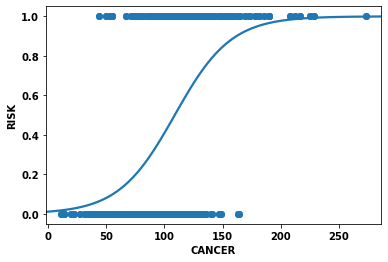

In [4]:
sns.regplot(x="CANCER", y="RISK", data=df, logistic=True, ci=True)
plt.show()

Selecting X (independent variables) and y (dependent binary variable).

In [5]:
X = df.iloc[:, 0:14].values
y = df.iloc[:, -1].values

Splitting the dataset into the Training set and Test set

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

Feature Scaling

In [7]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

Fitting Logistic Regression to the Training set

In [8]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

C:\Users\marco\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Predicting the Test set results

In [9]:
y_pred = classifier.predict(X_test)

Making the Confusion Matrix

In [10]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[294,  60],
       [ 68, 169]], dtype=int64)

Text(0.5, 257.44, 'Predicted label')

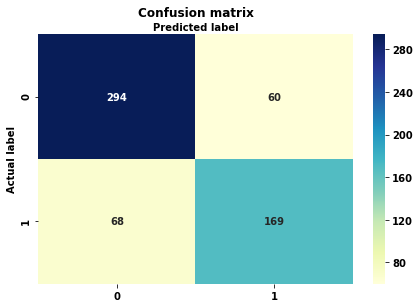

In [11]:
class_names = [0, 1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

Checking Evaluation metrics

In [12]:
from sklearn import metrics
#print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Precision: 0.7379912663755459
Recall: 0.7130801687763713


0.25

- Precision: When the model makes a prediction, how often it is correct.
In our case, when the Logistic Regression model predicted cities belong to a high risk cluster, the prediction was correct 71% of the time.
- Recall: If there are cities in a high risk cluster in the test set, the model can identify them 72% of the time.

0.5

- Precision: 0.7379912663755459
- Recall: 0.7130801687763713

Plotting the ROC curve

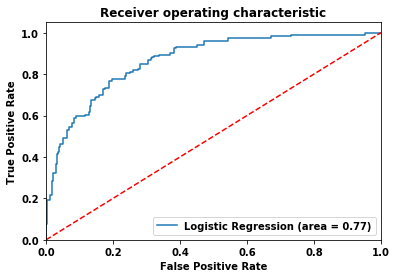

In [13]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

plt.rc("font", size=10)
logit_roc_auc = roc_auc_score(y_test, classifier.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, classifier.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

Selecting most significant features

In [14]:
from sklearn.feature_selection import RFE
selector = RFE(classifier, n_features_to_select=1, step=1)
selector = selector.fit(X_train, y_train)
rank = selector.ranking_

C:\Users\marco\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\marco\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\marco\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\marco\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\marco\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

Features: rank of significance

In [15]:
significant_features = list()
for i in range(len(df.columns) - 1):
    significant_features.append((rank[i], df.columns[i]))
significant_features.sort(key=lambda x:x[0])
significant_features

[(1, 'CANCER'),
 (2, 'DPOC'),
 (3, 'EPILEPSIA'),
 (4, 'ENXAQUECA'),
 (5, 'DOENCA_DE_PARKINSON'),
 (6, 'INSUFICIENCIA_RENAL'),
 (7, 'ESCLEROSE_MULTIPLA'),
 (8, 'HIPERTENSAO_ESSENCIAL'),
 (9, 'DIABETES_MELLITUS'),
 (10, 'INSUFICIENCIA_CARDIACA'),
 (11, 'DORSOPATIAS'),
 (12, 'AIDS'),
 (13, 'OSTEOPOROSE'),
 (14, 'ASMA')]

* 0.25

[(1, 'CANCER'),
 (2, 'DPOC'),
 (3, 'EPILEPSIA'),
 (4, 'ENXAQUECA'),
 (5, 'INSUFICIENCIA_RENAL'),
 (6, 'INSUFICIENCIA_CARDIACA'),
 (7, 'DOENCA_DE_PARKINSON'),
 (8, 'DORSOPATIAS'),
 (9, 'ESCLEROSE_MULTIPLA'),
 (10, 'ASMA'),
 (11, 'HIPERTENSAO_ESSENCIAL'),
 (12, 'DIABETES_MELLITUS'),
 (13, 'AIDS'),
 (14, 'OSTEOPOROSE')]
 
 * 0.5
 
[(1, 'CANCER'),
 (2, 'DPOC'),
 (3, 'EPILEPSIA'),
 (4, 'ENXAQUECA'),
 (5, 'DOENCA_DE_PARKINSON'),
 (6, 'INSUFICIENCIA_RENAL'),
 (7, 'ESCLEROSE_MULTIPLA'),
 (8, 'HIPERTENSAO_ESSENCIAL'),
 (9, 'DIABETES_MELLITUS'),
 (10, 'INSUFICIENCIA_CARDIACA'),
 (11, 'DORSOPATIAS'),
 (12, 'AIDS'),
 (13, 'OSTEOPOROSE'),
 (14, 'ASMA')]

## Testing with 2018 data

Creating a df with the disease rates for each city. Now, we'll predict if the cities belong or not to the high RISK cluster (1, if it belongs to a high risk cluster, and 0 otherwise).

In [22]:
disease = ""
path = '../../TabNet/Rates/2018/'
all_files = glob.glob(path + "*.csv")
diseases_list = []
for file in all_files:
    file_name = file.split("\\")[1]
    disease = file_name.split("_RATE")[0]
    disease_df = pd.read_csv(path + disease + '_RATE_18.csv', sep=',', index_col=0)
    disease_df = disease_df[["RATE", "MUNCOD"]]
    disease_df.rename(columns={"RATE": disease}, inplace=True)

    all_diseases = pd.merge(disease_df, all_diseases, left_on="MUNCOD", right_on="MUNCOD", how="inner")
df = all_diseases.drop('MUNCOD', 1)
df = df.drop(['TRAUMATISMO_INTRACRANIANO', 'HIV'], 1)
df

KeyError: "['TRAUMATISMO_INTRACRANIANO'] not found in axis"